In [27]:
# model library
import tensorflow as tf

# image processing libraries
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image

# data processing libraries
import numpy as np
import matplotlib.pyplot as plt
import math

# folder reading libraries
import glob
import os

### Loading in model

In [28]:
model = tf.keras.models.load_model('../model/cyclic_voltammogram_model')

# add another layer to convert to probabilities
cv_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()]) # softmax layer converts inputs to probabilities


### Loading in experimental data

In [29]:
def gather_png_data(folder_path): # function to read in PNG image files
    files = glob.glob(folder_path + "/*.png")
    img_array = []
    # left and top pixel until right and bottom pixel to crop that were arbitrarily set
    l,t,r,b = 30,0,400,390 
    
    for img in files:
        img = load_img(img, color_mode = "grayscale")
        img = img.crop((l,t,r,b)) # cropping is better for model & training
        img = img_to_array(img)  # convert PIL format to numpy array (note: 255 is white and 0 black)
        img_array.append(img)
    img_array = np.array(img_array)
    # normalizing: maps values to 0-1 such that 0 is white, 1 is black
    img_array = -(img_array/255) + 1
    return img_array

def listdir_non_hidden(folder_path): # function to only gather non-hidden folders
    folders = []
    for folder in os.listdir(folder_path):
        if not folder.startswith('.'):
            folders.append(folder)
    return folders

rel_folder_path = ("../data/experimental data/") # folder path of experimental data relative to code, note: add "/" at end
categories = listdir_non_hidden(rel_folder_path)
data = []
class_names = []

# iterates through data folder and appends data into a list
for folders in categories:
    datas = gather_png_data(rel_folder_path + folders)
    data.append(datas)

exp_data = np.vstack(data)

# generates category labels based on training data folder names
training_folder = '../data/training data/data (E,v,lambda)/Line Plots'
data_folder = listdir_non_hidden(training_folder)
labels = []
for folders in data_folder:
    labels.append(folders)

### Predicting data

In [30]:
predictions = cv_model.predict(exp_data, batch_size = 32)

1/1 [==============================] - 0s 83ms/step


### Functions to display images

In [31]:
def display_predictions(i): # takes in the position of exprimental data 
    fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 2]}, figsize=(15,5))
    # first subplot
    ax[0].imshow(exp_data[i], cmap= "binary")
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    # second subplot 
    thisplot = ax[1].bar(range(len(labels)), predictions[i], color="#FFCCCB")
    ax[1].set_xticks(range(len(labels)))
    ax[1].set_yticks([])
    ax[1].set_ylim([0,1])
    predicted_label = np.argmax(predictions[i])
    thisplot[predicted_label].set_color('#90EE90')
    
    ax[1].set_title(f"Predicted Category: {predicted_label} ({labels[predicted_label]})", size = 20)
    # to label each bar with percentage on top   
    for i, v in enumerate(predictions[0]):
        ax[1].text(i - 0.5, v + 0.01, str(round(v*100,2)) + '%', color='blue', rotation = 45, size = 8)
    

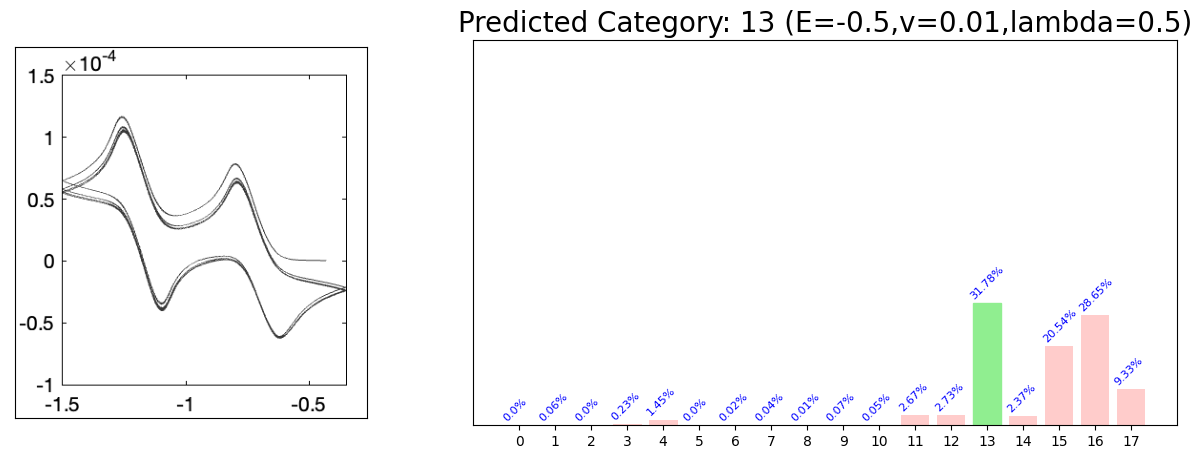

In [32]:
display_predictions(0)